<a href="https://colab.research.google.com/github/gurpreet-singh135/Image-Interpolation-via-separable-convolution/blob/priyansh/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import cv2 
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers
# from cv2.cuda import NvidiaOpticalFlow_1_0
import numpy as np

In [0]:
# f1=np.zeros((5,3),dtype="float")
# frame1 = (cv2.imread('basketball1.png', cv2.IMREAD_GRAYSCALE))
# frame2 = (cv2.imread('basketball2.png', cv2.IMREAD_GRAYSCALE))

# nvof = cv2.cuda_NvidiaOpticalFlow_1_0.create(frame1.shape[1], frame1.shape[0], 5, False, False, False, 0)

# flow = nvof.calc(frame1, frame2, None)
def decode_image(image_data,height,width):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, (150,150,3)) # explicit size needed for TPU
    return image
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "img1": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "img2": tf.io.FixedLenFeature([], tf.string),
        "img3": tf.io.FixedLenFeature([], tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64)
        # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    img1 = decode_image(example['img1'],height,width)
    img2 = decode_image(example['img2'],height,width)
    img3 = decode_image(example['img3'],height,width)

    return img1,img2,img3,height,width


In [0]:
dataset = tf.data.TFRecordDataset("/content/sample_data/patches3.tfrecord")
dataset = dataset.cache()
dataset = dataset.map(read_labeled_tfrecord)
dataset = dataset.shuffle(2500)


In [0]:
# print(dataset.shape)
def transform_dataset(img1,img2,img3,height,width):
  center_x=random.randint(39,111)
  center_y=random.randint(39,111)
  # print(img1.shape)
  img1=img1[center_x-39:center_x+39+1,center_y-39:center_y+39+1,:]
  img3=img3[center_x-39:center_x+39+1,center_y-39:center_y+39+1,:]
  # print(img1.shape)
  img1=tf.concat([img1,img3],-1)
  # print(img1.shape)
  return img1,img2[center_x,center_y,:]

dataset=dataset.map(transform_dataset)

In [0]:
inputs=tf.keras.layers.Input(shape=[79,79,6])
x=tf.keras.layers.BatchNormalization()(inputs)
x=(tf.keras.layers.Conv2D(kernel_size=7, filters=32, padding='valid', activation='relu')(x))
x=(tf.keras.layers.BatchNormalization()(x))
x=(tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='valid',strides=(2,2), activation='relu')(x))
x=(tf.keras.layers.Conv2D(kernel_size=5, filters=64, padding='valid', activation='relu')(x))
x=(tf.keras.layers.BatchNormalization()(x))
x=(tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='valid',strides=(2,2), activation='relu')(x))
 
x=(tf.keras.layers.Conv2D(kernel_size=5, filters=128, padding='valid', activation='relu')(x))
x=(tf.keras.layers.BatchNormalization()(x))
x=(tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='valid',strides=(2,2), activation='relu')(x))
 
x=(tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='valid', activation='relu')(x))
x=(tf.keras.layers.BatchNormalization()(x))
x=(tf.keras.layers.Conv2D(kernel_size=4, filters=2048, padding='valid', activation='relu')(x))
x=(tf.keras.layers.Conv2D(kernel_size=1, filters=3362, padding='valid', activation='softmax')(x))
x=tf.keras.layers.Reshape((41,82,1))(x)
# x1=np.array(x)
image_tensors=tf.split(inputs,num_or_size_splits=2,axis=-1)
kernel_tensors=tf.split(x,num_or_size_splits=2,axis=-2)
img1=image_tensors[0][:,19:60,19:60,0:3]
img2=image_tensors[1][:,19:60,19:60,0:3]
output1=img1*kernel_tensors[0]
output2=img2*kernel_tensors[1]
pixel1=tf.math.reduce_sum(output1,axis=[1,2],keepdims=True)
pixel2=tf.math.reduce_sum(output2,axis=[1,2],keepdims=True)
pixel=tf.squeeze(pixel1,axis=[1,2])+tf.squeeze(pixel2,axis=[1,2])
outputs=pixel


In [0]:
def custom_loss_function(logits,labels):
  loss=logits-labels
  loss=tf.keras.backend.abs(loss)
  loss=tf.math.reduce_sum(loss)
  return loss

In [221]:
model2=tf.keras.models.Model(inputs=inputs,outputs=pixel)
model2.compile(
  optimizer='adamax',
  loss= custom_loss_function,
  metrics=['accuracy'])
model2.summary()


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           [(None, 79, 79, 6)]  0                                            
__________________________________________________________________________________________________
batch_normalization_421 (BatchN (None, 79, 79, 6)    24          input_86[0][0]                   
__________________________________________________________________________________________________
conv2d_757 (Conv2D)             (None, 73, 73, 32)   9440        batch_normalization_421[0][0]    
__________________________________________________________________________________________________
batch_normalization_422 (BatchN (None, 73, 73, 32)   128         conv2d_757[0][0]                 
___________________________________________________________________________________________

In [222]:
print(inputs.shape)
dataset=dataset.batch(64)

(None, 79, 79, 6)


In [0]:
validation_dataset=dataset.take(16)
dataset=dataset.take(128)

In [225]:
history = model2.fit(dataset, epochs=20,validation_data=validation_dataset)

Epoch 1/20
40/40 [==============================] - 255s 6s/step - loss: 6.8017 - accuracy: 0.9296 - val_loss: 5.8102 - val_accuracy: 0.9326
Epoch 2/20
40/40 [==============================] - 253s 6s/step - loss: 6.0612 - accuracy: 0.9348 - val_loss: 5.4946 - val_accuracy: 0.9346
Epoch 3/20
40/40 [==============================] - 254s 6s/step - loss: 5.9479 - accuracy: 0.9332 - val_loss: 5.5575 - val_accuracy: 0.9434
Epoch 4/20
40/40 [==============================] - 255s 6s/step - loss: 5.7925 - accuracy: 0.9332 - val_loss: 5.6515 - val_accuracy: 0.9326
Epoch 5/20
40/40 [==============================] - 252s 6s/step - loss: 5.6336 - accuracy: 0.9348 - val_loss: 5.4655 - val_accuracy: 0.9355
Epoch 6/20
40/40 [==============================] - 252s 6s/step - loss: 5.5515 - accuracy: 0.9320 - val_loss: 5.5158 - val_accuracy: 0.9346
Epoch 7/20
40/40 [==============================] - 252s 6s/step - loss: 5.3543 - accuracy: 0.9356 - val_loss: 5.7083 - val_accuracy: 0.9326
Epoch 8/20
40

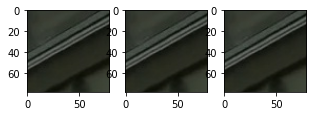

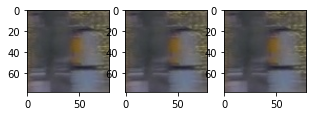

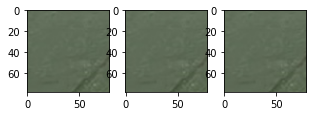

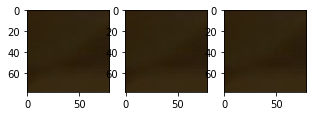

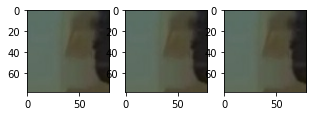

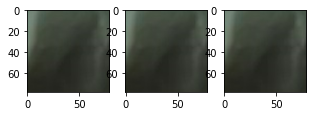

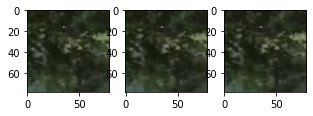

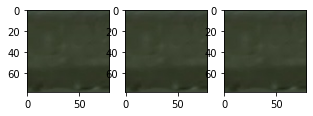

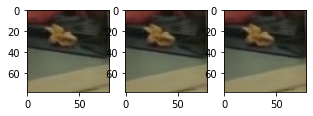

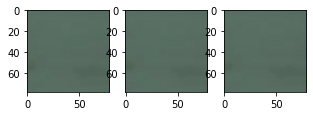

In [165]:
for image_features in dataset.take(10):
    w=20
    h=20
    fig=plt.figure(figsize=(5, 5))
    columns = 3
    rows = 1
    for i in range(1, columns*rows +1):
        img = image_features[0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

In [0]:
model = tf.keras.Sequential()
  # input: images of size 192x192x3 pixels (the three stands for RGB channels)
inputs=tf.keras.layers.Input(shape=(79,79,6))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(kernel_size=7, filters=32, padding='valid', activation='relu', input_shape=[79, 79, 6]))
model.add(tf.keras.layers.BatchNormalization())
  # tf.keras.layers.Activation("relu")
model.add(tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='valid',strides=(2,2), activation='relu'))
  # tf.keras.layers.MaxPooling2D(pool_size=2),
model.add(tf.keras.layers.Conv2D(kernel_size=5, filters=64, padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='valid',strides=(2,2), activation='relu'))
 
model.add(tf.keras.layers.Conv2D(kernel_size=5, filters=128, padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='valid',strides=(2,2), activation='relu'))
 
model.add(tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='valid', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(kernel_size=4, filters=2048, padding='valid', activation='relu'))
model.add(tf.keras.layers.Conv2D(kernel_size=1, filters=3362, padding='valid', activation='softmax'))
# model.add(tf.keras.layers.Reshape((41,82)))



In [0]:
# tf.keras.layers.MaxPooling2D(pool_size=2),
  # tf.keras.layers.Conv2D(kernel_size=3, filters=6, padding='same', activation='relu'),
  # tf.keras.layers.Flatten(),
  # classifying into 5 categories
  # tf.keras.layers.Dense(5, activation='softmax')
# ])
# l = tf.keras.layers # syntax shortcut

# y = l.Conv2D(filters=32, kernel_size=3, padding='same',
#              activation='relu', input_shape=[192, 192, 3])(x) # x=input image

# module start: branch out
# y1 = l.Conv2D(filters=32, kernel_size=1, padding='same', activation='relu')(y)
# y3 = l.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(y)
# y = l.concatenate([y1, y3]) # output now has 64 channels
# module end: concatenation

# many more layers ...

# Create the model by specifying the input and output tensors.
# Keras layers track their connections automatically so that's all that's needed.
# z = l.Dense(5, activation='softmax')(y)






  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Conv2D(kernel_size=7, filters=32, padding='valid', activation='relu', input_shape=[79, 79, 6]),
  # tf.keras.layers.BatchNormalization(),
  # # tf.keras.layers.Activation("relu")
  # tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='valid',strides=(2,2), activation='relu'),
  # # tf.keras.layers.MaxPooling2D(pool_size=2),
  # tf.keras.layers.Conv2D(kernel_size=5, filters=64, padding='valid', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='valid',strides=(2,2), activation='relu'),
 
  # tf.keras.layers.Conv2D(kernel_size=5, filters=128, padding='valid', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='valid',strides=(2,2), activation='relu'),
 
  # tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='valid', activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Conv2D(kernel_size=4, filters=2048, padding='valid', activation='relu'),
  # tf.keras.layers.Conv2D(kernel_size=1, filters=3362, padding='valid', activation='softmax')





In [13]:
print(dataset)
# w=20
# h=20
# image_y=iter(dataset.take(10))
# image_x=iter(image_y)
# print(image_y)
# print(image_features)
# fig=plt.figure(figsize=(5, 5))
# columns = 3
# rows = 1
# for i in range(1, columns*rows +1):
#     # img = next(image_x)
#     # img=image_y(i)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()
# plt.show(tf.gather(dataset,[0,0]))
# display_9_images_from_dataset(dataset)
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


<ShuffleDataset shapes: ((None, None, None), (None, None, None), (None, None, None), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.int32, tf.int32)>


NameError: ignored

In [0]:
def make_variable(variable_shape, initializer=tf.keras.initializers.GlorotNormal()):
  return tf.Variable(initializer(shape=variable_shape, dtype=tf.float32))
def initialize_parameters():
  # Not making bias vector as it gets cancelled during normalization
  conv_kernel_height=3
  conv_kernel_width=3
  filter_sizes=(
                [],#To avoid using filter_sizes[0] for filter f1 and so on
                [conv_kernel_height,conv_kernel_width,6,32],
                [32,64,conv_kernel_height,conv_kernel_width],
                [64,128,conv_kernel_height,conv_kernel_width],
                [128,256,conv_kernel_height,conv_kernel_width],
                [256,512,conv_kernel_height,conv_kernel_width],
                [512,512,conv_kernel_height,conv_kernel_width]
                )
  f1 = make_variable(filter_sizes[1])
  f2 = make_variable(filter_sizes[2])
  f3 = make_variable(filter_sizes[3])
  f4 = make_variable(filter_sizes[4])
  f5 = make_variable(filter_sizes[5])
  f6 = make_variable(filter_sizes[6])
  print(f3.shape,f6.shape)
  parameters = {  "f1": f1,
                  "f2": f2,
                  "f3": f3,
                  "f4": f4,
                  "f5": f5,
                  "f6": f6}
    
  return parameters


In [4]:
# print(f1)
# v1, v2 = make_variables(3, tf.initializers.GlorotNormal())
# print(v1)
parameters=initialize_parameters()
print(parameters["f1"].shape)

# print(f5)


(64, 128, 3, 3) (512, 512, 3, 3)
(3, 3, 6, 32)


In [5]:

f1=parameters["f1"]
f2=parameters["f2"]
print(f1.shape)

(3, 3, 6, 32)


In [0]:
x1=make_variable([1,150,150,6])
# x2=make_variable([3,150,150])
# x_in = np.array([[
#   [[2], [1], [2], [0], [1]],
#   [[1], [3], [2], [2], [3]],
#   [[1], [1], [3], [3], [0]],
#   [[2], [2], [0], [1], [1]],
#   [[0], [0], [3], [1], [2]], ]])
# kernel_in = np.array([
#  [ [[2, 0.1]], [[3, 0.2]] ],
#  [ [[0, 0.3]],[[1, 0.4]] ], ])
# x = tf.constant(x_in, dtype=tf.float32)
# kernel = tf.constant(kernel_in, dtype=tf.float32)
# print(x.shape,kernel_in.shape)
# print(tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID'))
# print(tf.nn.convolution(x, kernel, strides=[1, 1, 1, 1], padding='VALID'))

d3=tf.nn.convolution(x1,f1)

In [7]:
print(d3.shape)
d4=make_variable([1,0,0,32])

(1, 148, 148, 32)
